In [27]:
import os
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from random import sample
from alpaca_trade_api.rest import REST, TimeFrame
from MCForecastTools import MCSimulation
from dotenv import load_dotenv
from datetime import datetime

In [28]:
load_dotenv()
api_key=os.getenv("ALPACA_API_KEY")
api_secret_key=os.getenv("ALPACA_SECRET_KEY")
api = REST(api_key , api_secret_key, api_version='v2')

In [29]:
def get_data(ticker_name, start_date, end_date):   
    df_ticker = api.get_bars(ticker_name, TimeFrame.Day, start_date, end_date, adjustment='raw').df
    df_ticker.index = df_ticker.index.date
    df_ticker=df_ticker[['close']]
    return df_ticker

In [30]:
msft = get_data('MSFT', '2021-03-01', '2022-03-01')
msft.head()

,close
2021-03-01,236.94
2021-03-02,233.87
2021-03-03,227.56
2021-03-04,226.73
2021-03-05,231.60


In [35]:
def plot_MC(ticker, start_date, end_date, num_days=10): 
    df = get_data(ticker, start_date, end_date)
    initial_price = df.iloc[-1].values[0]
    
    pct_changes = df.pct_change()
    pct_changes.dropna(inplace=True)
    pct_changes.index = pd.to_datetime(pct_changes.index)
    
    possible_changes = list(pct_changes['close'].values)
    print(f"{len(possible_changes)}")

    plt.figure(figsize=(20,10))

    realizations = []
    for i in range(0, 500): 

        current_price = initial_price 
        current_price_history = []
        for i in range(num_days): 
            current_pct_change = sample(possible_changes,1)[0]
            current_price = current_price * (1+ current_pct_change)
            current_price_history.append(current_price)


        plt.plot(current_price_history)
        plt.title(f"Monte Carlo Simulation for {ticker}")

        realizations.append(current_price_history)
        
    plt.show()
    
    closing_prices_as_of_last_day = [x[-1] for x in realizations]
    expected_return = (np.mean(closing_prices_as_of_last_day) - initial_price)/initial_price
    low_bound =  np.mean(closing_prices_as_of_last_day)  - 2*np.std(closing_prices_as_of_last_day)
    upper_bound =  np.mean(closing_prices_as_of_last_day)  + 2*np.std(closing_prices_as_of_last_day)

    print(f"\nThe starting closing price at the end of this period was {initial_price}")
   
    print(f"\nThe expected return on {ticker} is {expected_return} and the closing price will be between \
            {low_bound} and {upper_bound} with 95% confidence in the next {num_days} trading days")
    
    low_bound =  np.mean(closing_prices_as_of_last_day)  - 1*np.std(closing_prices_as_of_last_day)
    upper_bound =  np.mean(closing_prices_as_of_last_day)  + 1*np.std(closing_prices_as_of_last_day)
    
    #print(f"\nThe starting closing price at the end of this period was {initial_price}")
    print(f"\nThe expected return on {ticker} is {expected_return} and the closing price will be between \
            {low_bound} and {upper_bound} with 67% confidence in the next {num_days} trading days")




517


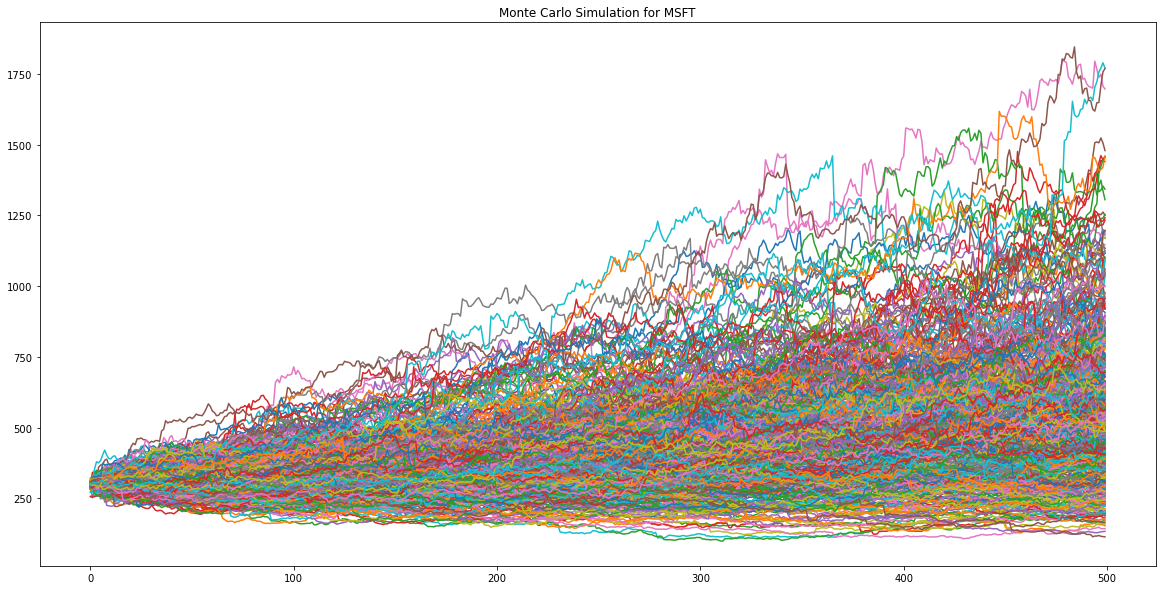


The starting closing price at the end of this period was 300.43

The expected return on MSFT is 0.8938502866810123 and the closing price will be between             7.0772936254400065 and 1130.861589629713 with 95% confidence in the next 500 trading days

The expected return on MSFT is 0.8938502866810123 and the closing price will be between             288.0233676265083 and 849.9155156286448 with 67% confidence in the next 500 trading days


In [36]:
plot_MC('MSFT', '2020-03-01', '2022-03-20',500)